# US Historical Stock Data Analysis

Data set: https://www.kaggle.com/tsaustin/us-historical-stock-prices-with-earnings-data

Please download and put the file "stock_prices_latest.csv" in the same folder as this ipynb file.

# Data and Stock statistical analysis

In [1]:
import pandas as pd
import numpy as np
from dask import dataframe as dd
import time
# Pandas method
# start_time = time.time()
# data = pd.read_csv('stock_prices_latest.csv')
# describe = data.describe()
# print(data.info(memory_usage='deep'))
# describe.to_csv("describe.csv")
# Data.groupby(['symbol']).agg(['min','max','mean', 'count'])
# Data.groupby(['symbol']).agg(['min','max','mean', 'count']).to_csv("groups.csv")
# end_time = time.time()
# print("run time = {}".format(end_time - start_time))

data = dd.read_csv('stock_prices_latest.csv')
# print("df.head",df.head)
data_describe = data.describe().compute()
# print("data.head",data.head)
data_describe.to_csv("stock_prices_describe.csv")

data_mean = data.groupby('symbol').mean().compute()
data_min = data.groupby('symbol').min().compute()
data_max = data.groupby('symbol').max().compute()
data_count = data.groupby('symbol').count().compute()

data_min.to_csv("Daskmin.csv")
data_max.to_csv("Daskmax.csv")
data_mean.to_csv("Daskmean.csv")
data_count.to_csv('Daskcount.csv')

# Data Cleaning

Replacing negative stock values to zeros.

Prepare data for regression.

In [2]:
import pandas as pd
import numpy as np
from dask import dataframe as dd

data = pd.read_csv('stock_prices_latest.csv')
num = data._get_numeric_data()
num[num < 0] = 0
data.to_csv("stock_prices_latest_Fixed_Negative.csv", index=False)

data = dd.read_csv('stock_prices_latest.csv')
data = data.drop(['open', 'high','low','close','volume','split_coefficient'], axis=1)
closeonly = data.compute()
closeonly.to_csv("DaskClose_adjustedonly.csv", index=False)

# Stock Manual Selection

We will display the FAANG stocks(Facebook, Amazon, Apple, Netflix and Google)

You may input the stock of interest.

In [3]:
import pandas as pd
import numpy as np
from dask import dataframe as dd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

data = pd.read_csv('stock_prices_latest_Fixed_Negative.csv')

FAANG = ['AAPL','AMZN','FB','NFLX','GOOGL']
choice = input('Stock you want to know (Input Code or Enter to skip):  ')
choice = choice.upper()
if choice in list(data[data['symbol']==choice]['symbol']):
    FAANG.append(choice)    
else: print('Your input stock is not found.')
print('Analysis of the following stocks will be shown: ')
print(FAANG)

Stock you want to know (Input Code or Enter to skip):  GOOG
Analysis of the following stocks will be shown: 
['AAPL', 'AMZN', 'FB', 'NFLX', 'GOOGL', 'GOOG']


In [4]:
#Get single stock data
def getstock(stockname):
    Stockdf = data[data['symbol']==stockname]
    Stockdf = Stockdf.sort_values(by='date')
    Stockdf = Stockdf.set_index('date')
    
    # Analyze only close_adjusted
    Target = 'close_adjusted'
    Stockseries = pd.Series(Stockdf[Target]).rename(stockname)
    return Stockseries

# Golden Cross vs. Death Cross

By using moving average lines of 50 days and 200 days, we can see big changes in trend. 

One can input their interested start date of the range.

Ref:
https://www.bigtrends.com/education/moving-averages-golden-cross-death-cross-in-technical-analysis/

In [5]:
def movingavg(window1,window2,ss):
    global Sel_Stock
    ss_w1 = ss.rolling(window1).mean().rename(str(window1)+' day')
    ss_w2 = ss.rolling(window2).mean().rename(str(window2)+' day')
    return ss_w1, ss_w2

In [6]:
def findcross(line1,line2):
    #Look for the positions that the two lines swap up/down
    compare = np.array(line1)-np.array(line2)
    compareshift = np.insert(compare[:-1],1,[0])
    twist = compare*compareshift < 0
    pos = [index for index in range(len(twist)) if twist[index]]
    
    #see if it is a Golden cross or Death cross
    Golden=[]
    Death=[]
    for i in pos:
        if compare[i]<0:
            Death.append(i)
        else: Golden.append(i)
            
    #combine in a DataFrame
    Golden_value = line1.rename('Golden').to_frame().iloc[Golden]
    Death_value = line1.rename('Death').to_frame().iloc[Death]
    Cross_df = Golden_value.join(Death_value,how='outer')
    return Cross_df

In [7]:
#plotting Golden cross and Death cross
def GDplot(plt_df,timeframe):
    sns.set(rc={'figure.figsize':(20, 8)})
    plt_df = plt_df[timeframe:]
    global window1, window2
    
    fig, ax = plt.subplots()
    ax.plot(plt_df['Golden'], marker='o', markersize = 10, color='orange', linestyle='',label='Golden')
    ax.plot(plt_df['Death'], marker='o', markersize = 10, color='black', linestyle='',label='Death')
    ax.plot(plt_df[str(window1)+' day'], marker='', markersize = 0, linestyle='-',label=str(window1)+' day')
    ax.plot(plt_df[str(window2)+' day'], marker='', markersize = 0, linestyle='-',label=str(window2)+' day')
    ax.plot(plt_df[plt_df.columns[0]], marker='', markersize = 0, linestyle='-',label=plt_df.columns[0])
    ax.set_title(plt_df.columns[0]+"'s Golden Cross vs. Death Cross", size=30)
    ax.xaxis.set_major_locator(mdates.MonthLocator());
   


Input the start date you want, or Enter to skip(default 2018-01-01): 2017-08-15


C:\Users\yenst\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\Users\yenst\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


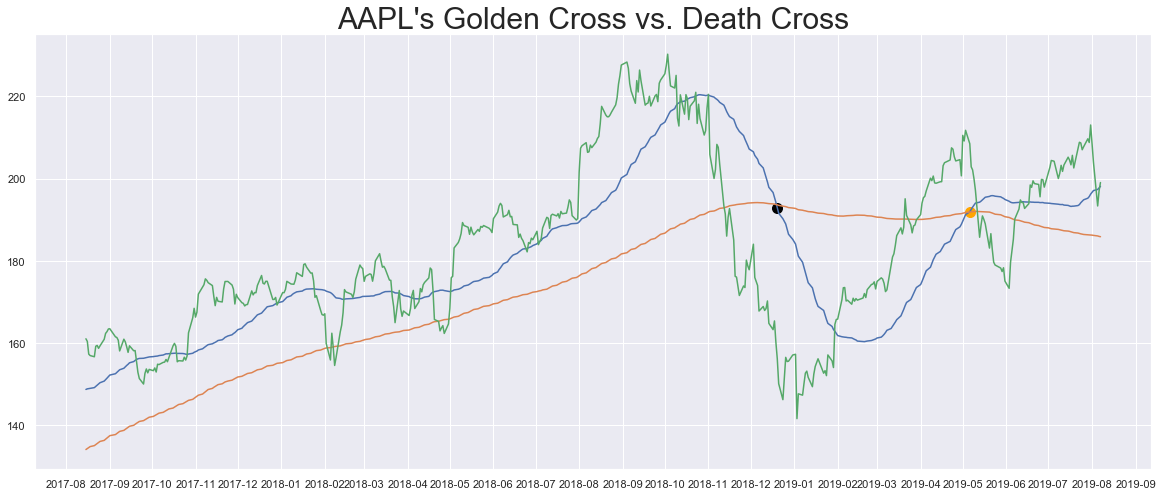

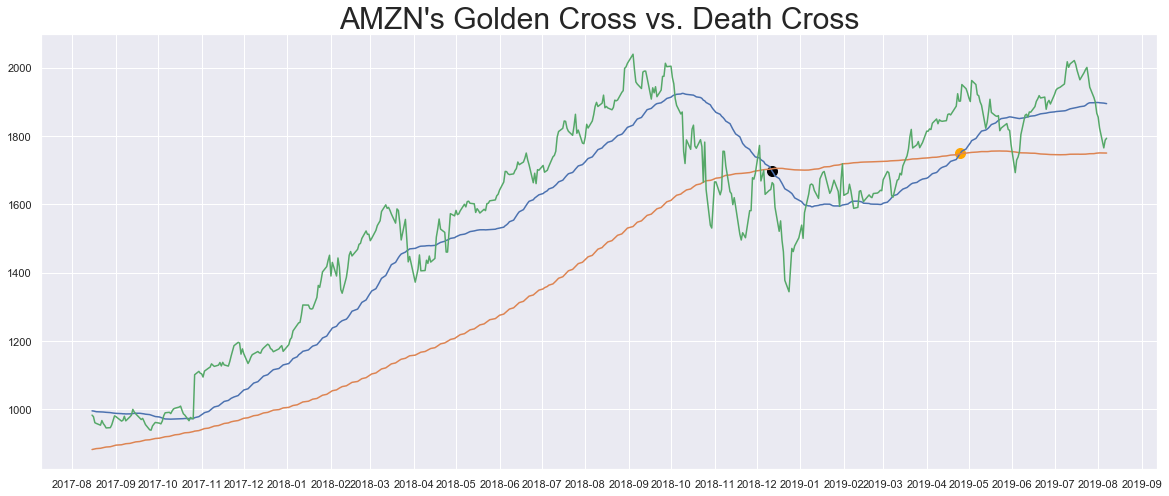

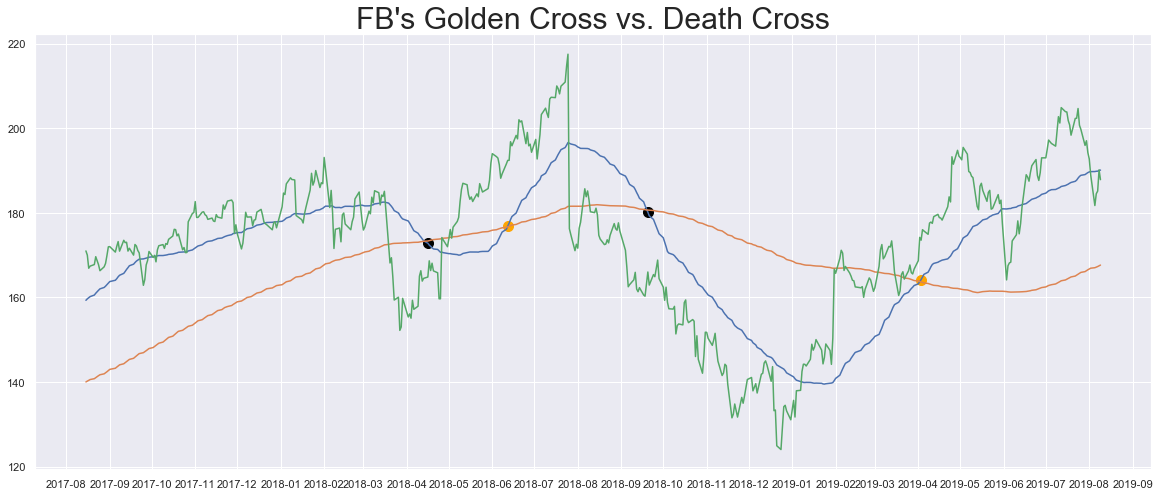

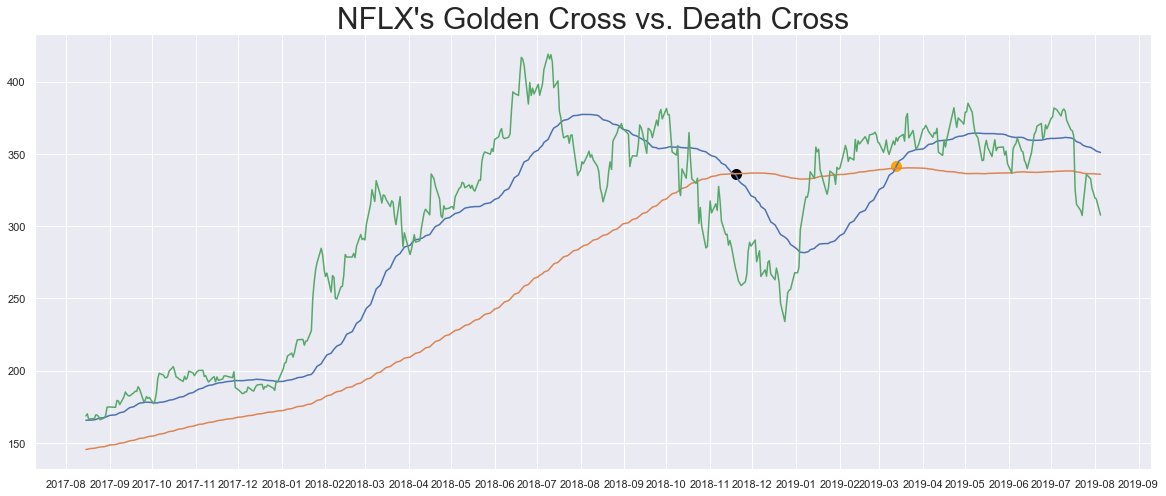

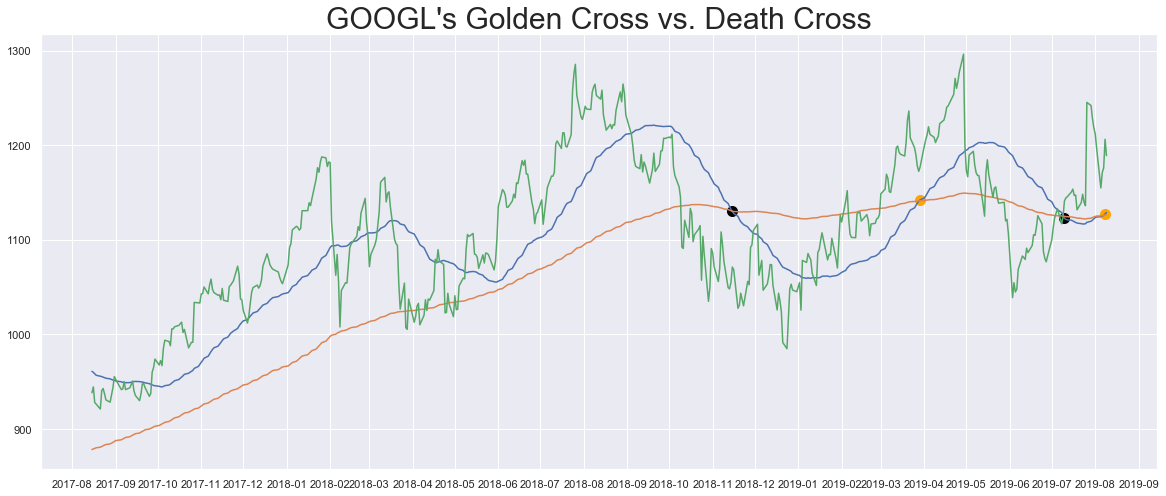

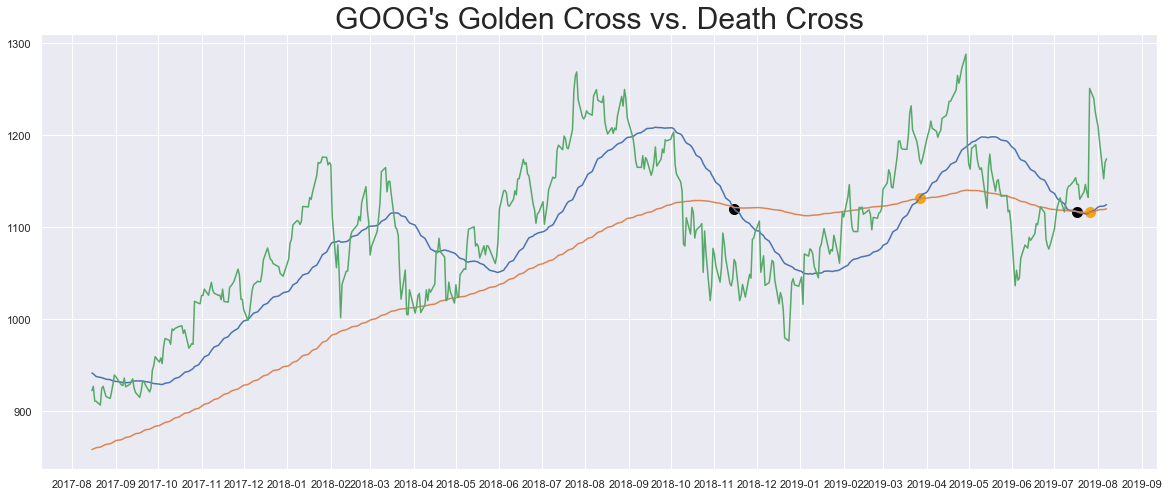

In [8]:
#Main
defaulttime = '2018-01-01'
timeframe = input('Input the start date you want, or Enter to skip(default 2018-01-01): ')
if timeframe=='':
    timeframe = defaulttime
    
for Sel_Stock in FAANG:
    Ser = getstock(Sel_Stock)
    window1, window2=50,200
    ss_w1, ss_w2 = movingavg(window1,window2,Ser)

    # combine everything into one dataframe for plotting
    plt_df = Ser.to_frame()
    plt_df = plt_df.merge(ss_w1,left_index=True,right_index=True)
    plt_df = plt_df.merge(ss_w2,left_index=True,right_index=True)

    Cross_df = findcross(ss_w1,ss_w2)
    plt_df = plt_df.merge(Cross_df, on='date', how='left')
    plt_df.index = pd.to_datetime(plt_df.index)

    GDplot(plt_df,timeframe)
    


# Bollinger Band

The 20 day moving average line with positive and negative standard deviation range

Link: https://www.pythonforfinance.net/2017/07/31/bollinger-band-trading-strategy-backtest-in-python/

In [9]:
def Bollinger(Ser,window,no_of_std):
    #Calculate rolling mean and standard deviation using number of days set above
    rolling_mean = Ser.rolling(window).mean()
    rolling_std = Ser.rolling(window).std()

    #create two new DataFrame columns to hold values of upper and lower Bollinger bands
    df = Ser.to_frame()
    df['Rolling Mean'] = rolling_mean
    df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
    df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)
    return df

In [10]:
def Bolplot(df, timeframe):
    sns.set(rc={'figure.figsize':(20, 8)})
    global Sel_stock
    df = df[timeframe:]
        
    fig, ax = plt.subplots()
    ax.plot(df['low'], marker='o', markersize = 8, linestyle='',label='Low')
    ax.plot(df['high'], marker='o', markersize = 8, linestyle='',label='High')
    ax.plot(df[[Sel_stock,'Bollinger High','Bollinger Low']], marker='', markersize = 0, linestyle='-')
    ax.set_title(Sel_stock+"'s Bollinger band", size=30)
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%mmm %y'));
    ax.xaxis.set_major_locator(mdates.MonthLocator());

In [11]:
def get_alerts(stockdata, lower, upper):
    low_arr = np.where(stockdata < lower)
    high_arr = np.where(stockdata > upper)
    low_list = df.iloc[low_arr]
    high_list = df.iloc[high_arr]
    global Sel_stock
    low_list = low_list[Sel_stock].rename('low')
    high_list = high_list[Sel_stock].rename('high')
    return low_list, high_list

Input number of STD, or Enter to skip(default 2):  2
Input start date you want, or Enter to skip(default 2018-01-01): 2017-08-15


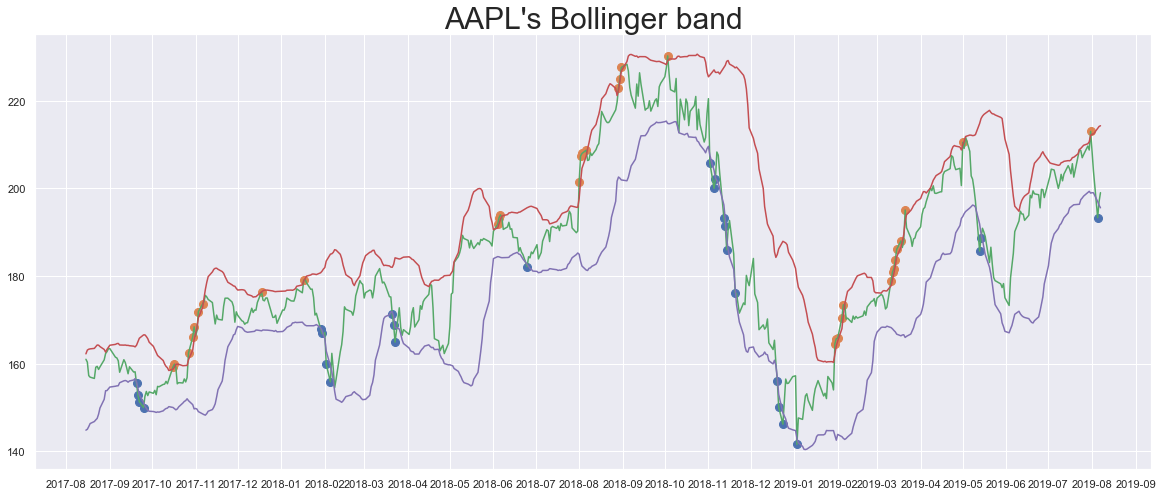

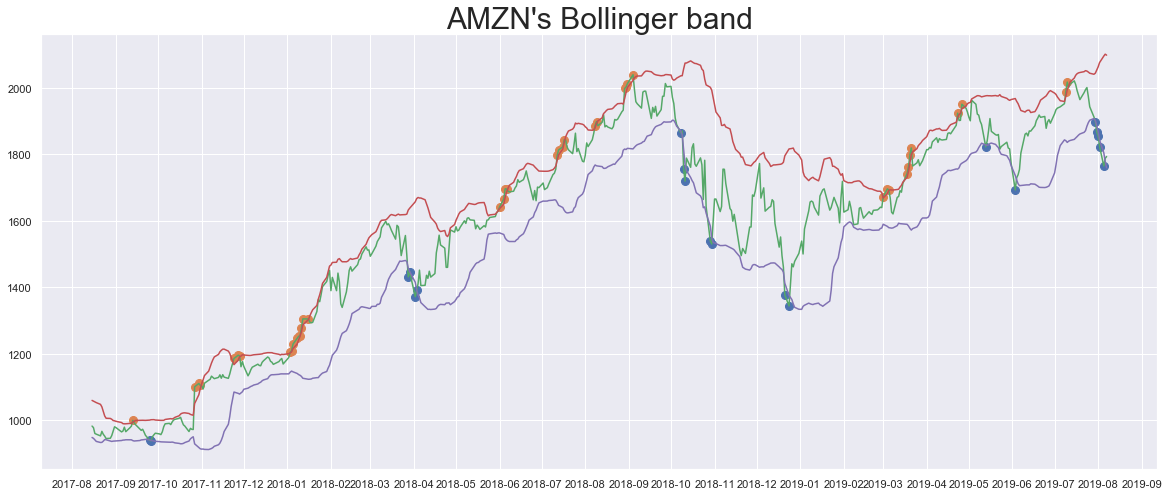

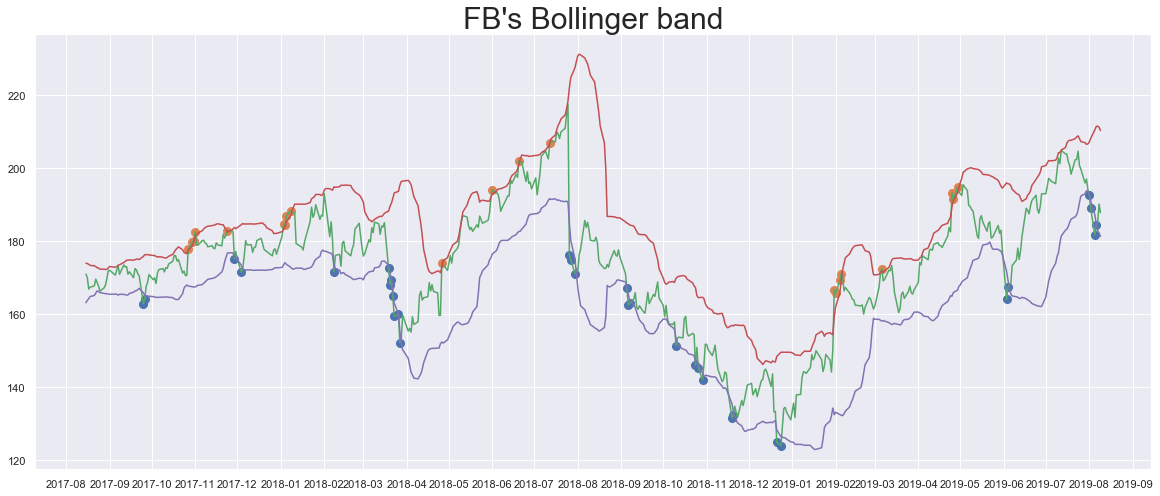

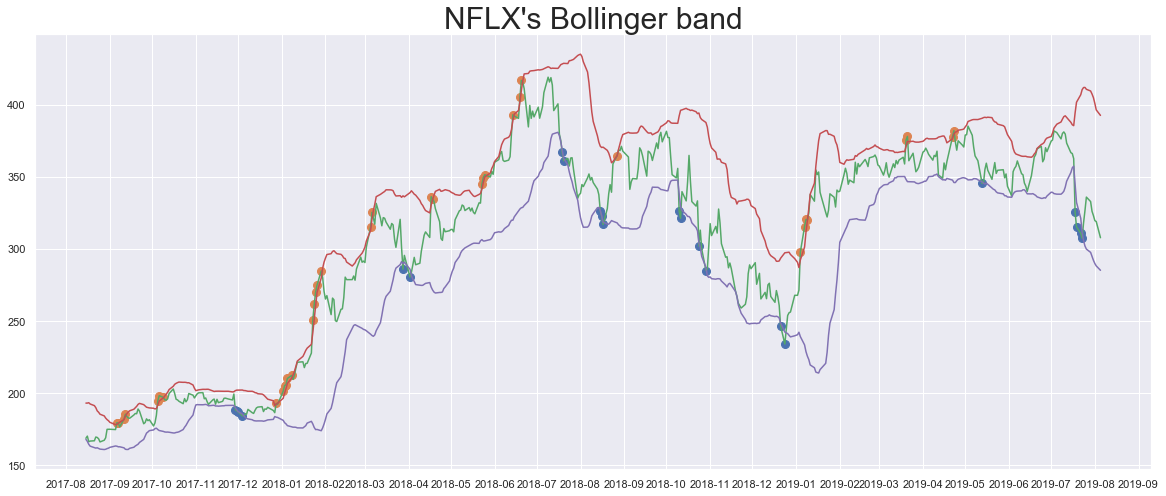

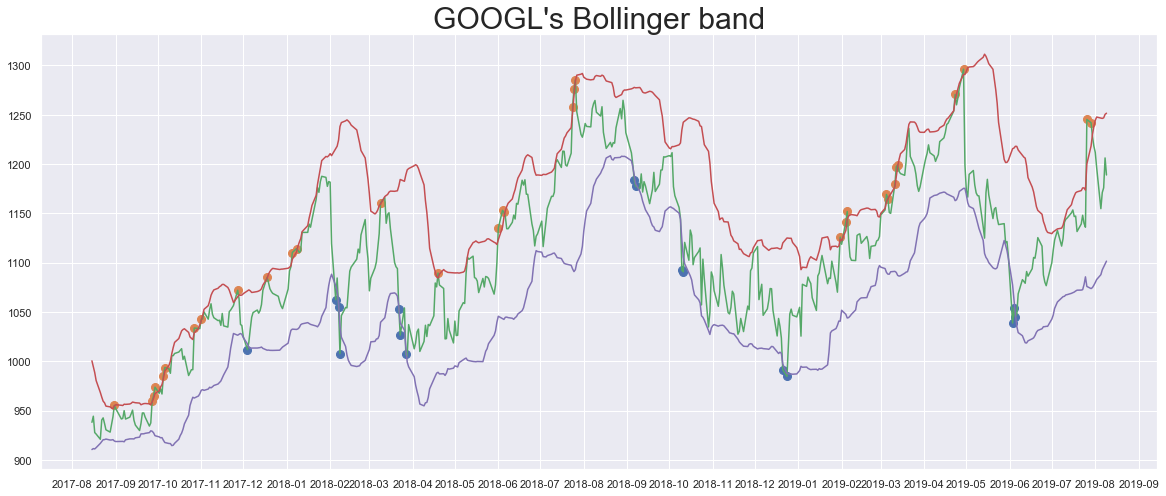

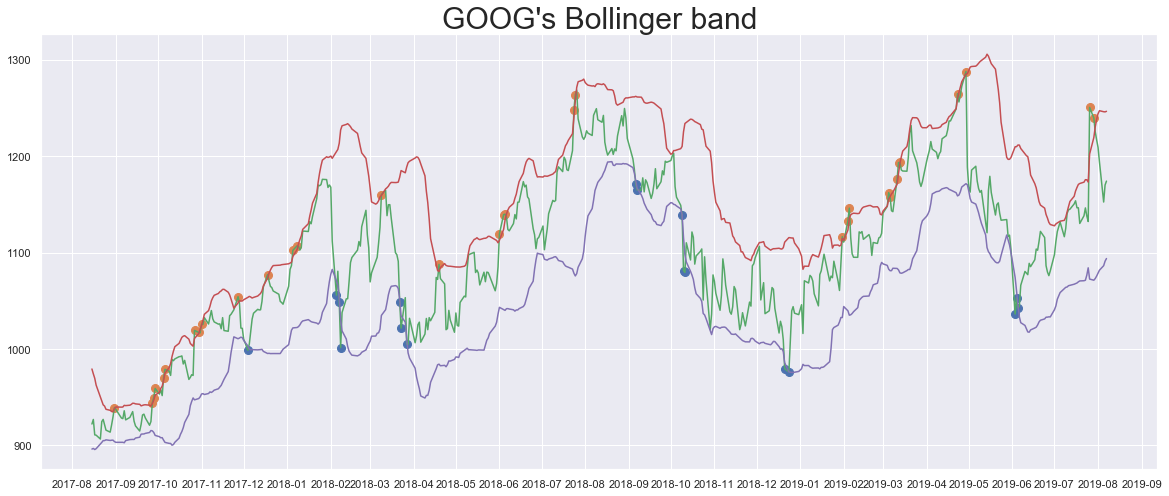

In [12]:
#Main
window = 20
defaultstd = 2
defaulttimeframe = '2018-01-01'

no_of_std = input('Input number of STD, or Enter to skip(default 2):  ')
timeframe = input('Input start date you want, or Enter to skip(default 2018-01-01): ')

if no_of_std =='':
    no_of_std = defaultstd
else: no_of_std = float(no_of_std)

if timeframe=='':
    timeframe = defaulttimeframe

for Sel_stock in FAANG:
    Ser = getstock(Sel_stock)
    df = Bollinger(Ser,window,no_of_std)    
    low, high = get_alerts(df[Sel_stock],df['Bollinger Low'],df['Bollinger High'])
    df = df.merge(low, on='date', how = 'left')
    df = df.merge(high, on='date', how = 'left')
    df.index = pd.to_datetime(df.index)
    Bolplot(df, timeframe)
    #Cross_value = line1.rename('cross').to_frame().iloc[pos]

# Linear and Polynomial Regression

In [13]:
import numpy as np
import pandas as pd
from dask import dataframe as dd

data = dd.read_csv('stock_prices_latest_Fixed_Negative.csv')
data = data.drop(['open', 'high','low','close','volume','split_coefficient'], axis=1)
df = data.compute()
df.to_csv("DaskClose_adjustedonly.csv", index=False)

please input the stock you want to analyse: AAPL


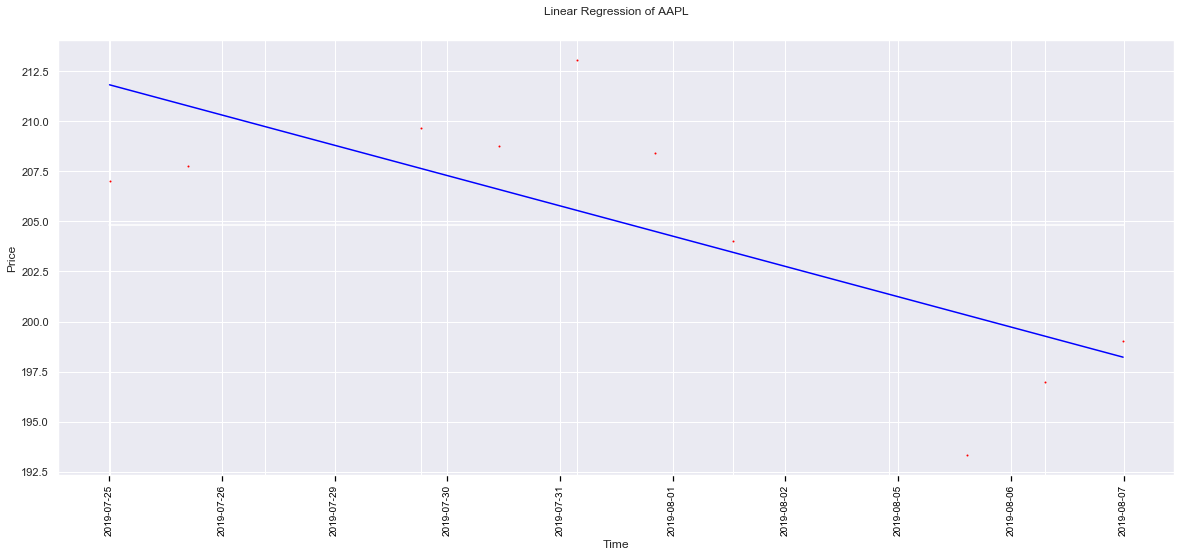

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

company = input("please input the stock you want to analyse: ")
dayrange = 10
data = pd.read_csv('DaskClose_adjustedonly.csv')
data = data.loc[data['symbol'] == company]
data = data.sort_values(by=['date'])
data.set_index(['date'])
data2 = data.copy()
data['date'] = pd.to_datetime(data['date'])
data['date_delta'] = (data['date'] - data['date'].min()).dt.days.astype('int16')
data["D"] = np.nan
data['D'] = data['date']
data['date'] = data['date_delta']
data['date_delta'] = data['D']
data.drop(['D'], axis=1)
data = data.iloc[-dayrange:]
data2 = data2.iloc[-dayrange:]
x = data.iloc[:, 1:2].values
x2 = data2.iloc[:,1]
y = data.iloc[:, 2].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(x, y)

def graphlinear():
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    ax2.plot(x, lin_reg.predict(x), color='blue')
    ax1.plot(x2, (np.ones(10) * np.mean(y)), color='white')
    
    plt.scatter(x, y, color='red',s=1)
    plt.title('Linear Regression of '+company)
    ax1.set_xlabel("Time")
    ax1.set_ylabel('Price')
    ax1.tick_params(axis='x', colors='black',labelrotation=90,labelsize="small")
    ax2.tick_params(axis='x', colors='white');
    # fig.savefig("1.png")
    return
graphlinear()

please input the stock you want to analyse: AAPL


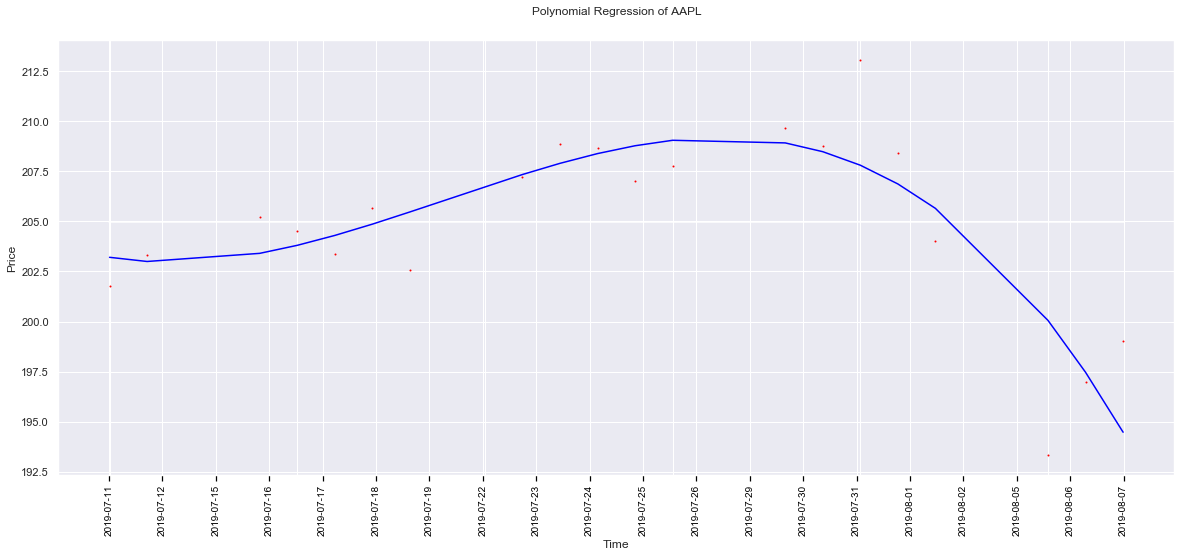

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
company = input("please input the stock you want to analyse: ")
dayrange = 20

data = pd.read_csv('DaskClose_adjustedonly.csv')
data = data.loc[data['symbol'] == company]
data = data.sort_values(by=['date'])
data.set_index(['date'])
data2 = data.copy()
data['date'] = pd.to_datetime(data['date'])
data['date_delta'] = (data['date'] - data['date'].min()).dt.days.astype('int16')
data["D"] = np.nan
data['D'] = data['date']
data['date'] = data['date_delta']
data['date_delta'] = data['D']
data.drop(['D'], axis=1)
data = data.iloc[-dayrange:]
data2 = data2.iloc[-dayrange:]
x = data.iloc[:, 1:2].values
x2 = data2.iloc[:,1]
y = data.iloc[:, 2].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(x)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

def graphpoly():
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    ax2.plot(x, pol_reg.predict(poly_reg.fit_transform(x)), color='blue')
    ax1.plot(x2, (np.ones(20) * np.mean(y)), color='white') # need to find a way to make them tick every week or month
    plt.scatter(x, y, color='red',s=1)
    plt.title('Polynomial Regression of '+company)
    ax1.set_xlabel("Time")
    ax1.set_ylabel('Price')
    ax1.tick_params(axis='x', colors='black',labelrotation=90,labelsize="small")
    ax2.tick_params(axis='x', colors='white');
    # fig.savefig("1.png")
    return
graphpoly()